In [1]:
# Imports
import mne
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

Using: cuda


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


class EEGGANTrainer:
    """
    EEG GAN Trainer with small-dataset anti-overfitting protections.
    Supports: Vanilla GAN or WGAN-GP.

    Example:
        trainer = EEGGANTrainer(
            data, name="exp1", gan_type="wgan", device="cuda", latent_dim=128
        )
        trainer.train(epochs=100)
        fake = trainer.generate(100)
    """

    def __init__(self, data, name="experiment", device="cpu",
                 gan_type="vanilla", latent_dim=100, model_dir="../../models"):

        assert isinstance(data, np.ndarray) and data.ndim == 3, \
            "data must be numpy array (n_samples, n_channels, n_timepoints)"

        self.data = data.astype(np.float32)
        self.name = name
        self.gan_type = gan_type.lower()
        self.latent_dim = latent_dim
        self.model_dir = model_dir

        # Device selection
        self.device = torch.device(device if torch.cuda.is_available() else "cpu")

        self.n_samples, self.n_channels, self.n_timepoints = data.shape
        self.data_size = self.n_channels * self.n_timepoints

        print(f"Initialized EEGGANTrainer ({gan_type}) — {name}")
        print(f"  Data: {self.data.shape}")
        print(f"  Device: {self.device}")

        if self.n_samples < 500:
            print("⚠️ WARNING: Small dataset detected (<500)")
            print("   → Using smaller models")
            print("   → Early stopping enabled")

        self._create_models()
        self._create_dataset()

        self.history = {"G_losses": [], "D_losses": [], "metrics": []}
        self.best_metric = float("inf")
        self.best_epoch = 0

    # -------------------------------------------------------------
    # MODEL CREATION
    # -------------------------------------------------------------
    def _create_models(self):
        """Model selector wrapper."""
        # Always use conv models (better for EEG)
        self._create_conv_models()

    def _create_conv_models(self):
        """Conv1D Generator + Critic."""
        C, T = self.n_channels, self.n_timepoints

        # ------------------------
        # Generator
        # ------------------------
        self.G = nn.Sequential(
            nn.Linear(self.latent_dim, C * T),
            nn.Unflatten(1, (C, T)),

            nn.Conv1d(C, 128, 7, padding=3),
            nn.LayerNorm([128, T]),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),

            nn.Conv1d(128, 64, 7, padding=3),
            nn.LayerNorm([64, T]),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),

            nn.Conv1d(64, C, 7, padding=3),
        ).to(self.device)

        # ------------------------
        # Critic (Conv → Pool → FC)
        # ------------------------
        class ConvCritic(nn.Module):
            def __init__(self, C):
                super().__init__()
                self.conv = nn.Sequential(
                    nn.Conv1d(C, 64, 7, stride=2, padding=3),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.4),

                    nn.Conv1d(64, 128, 7, stride=2, padding=3),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.4),

                    nn.Conv1d(128, 256, 7, stride=2, padding=3),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.4),
                )
                self.pool = nn.AdaptiveAvgPool1d(1)
                self.fc = nn.Linear(256, 1)

            def forward(self, x):  # x: (B, C, T)
                h = self.conv(x)
                h = self.pool(h).squeeze(-1)
                return self.fc(h)

        self.D = ConvCritic(C).to(self.device)

        # ------------------------
        # Count params
        # ------------------------
        def count(m): return sum(p.numel() for p in m.parameters())
        print("✓ Created Conv1D Generator + Critic")
        print(f"  G params: {count(self.G):,}")
        print(f"  D params: {count(self.D):,}")

    # -------------------------------------------------------------
    # DATASET
    # -------------------------------------------------------------
    def _create_dataset(self):
        class EEGDataset(Dataset):
            def __init__(self, x): self.x = torch.from_numpy(x)
            def __len__(self): return len(self.x)
            def __getitem__(self, i): return self.x[i]

        dataset = EEGDataset(self.data)
        self.dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
        print(f"✓ Dataset loaded: {len(dataset)} samples")

    # -------------------------------------------------------------
    # GRADIENT PENALTY (fixed version)
    # -------------------------------------------------------------
    def _gradient_penalty(self, real, fake):
        """WGAN-GP penalty for Conv critic."""
        B = real.size(0)

        alpha = torch.rand(B, 1, 1, device=self.device)
        interp = (alpha * real + (1 - alpha) * fake).requires_grad_(True)

        pred = self.D(interp)
        grad = torch.autograd.grad(
            outputs=pred,
            inputs=interp,
            grad_outputs=torch.ones_like(pred),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]

        grad = grad.view(B, -1)
        return ((grad.norm(2, dim=1) - 1) ** 2).mean()

    # -------------------------------------------------------------
    # TRAIN ENTRY
    # -------------------------------------------------------------
    def train(self, epochs=100, lr=2e-4, save_best=True):
        if self.gan_type == "wgan" or self.gan_type == "wgan-gp":
            self._train_wgan_gp(epochs, lr, save_best)
        else:
            self._train_vanilla(epochs, lr, save_best)

    # -------------------------------------------------------------
    # VANILLA GAN TRAINING (unchanged but cleaned)
    # -------------------------------------------------------------
    def _train_vanilla(self, epochs, lr, save_best):
        criterion = nn.BCELoss()
        G_opt = optim.Adam(self.G.parameters(), lr=lr, betas=(0.5, 0.999))
        D_opt = optim.Adam(self.D.parameters(), lr=lr, betas=(0.5, 0.999))

        patience, no_improve = 20, 0
        print("\n=== Training Vanilla GAN ===")

        for ep in range(1, epochs + 1):
            G_losses, D_losses = [], []

            for real in self.dataloader:
                real = real.to(self.device)
                real = real + torch.randn_like(real) * 0.01
                B = real.size(0)

                # ---- Train D
                D_opt.zero_grad()
                real_score = self.D(real)
                real_labels = torch.ones(B, 1, device=self.device) * 0.9
                loss_real = criterion(real_score, real_labels)

                z = torch.randn(B, self.latent_dim, device=self.device)
                fake = self.G(z)
                fake_score = self.D(fake)
                fake_labels = torch.zeros(B, 1, device=self.device)
                loss_fake = criterion(fake_score, fake_labels)

                D_loss = (loss_real + loss_fake) / 2
                D_loss.backward()
                D_opt.step()

                # ----- Train G
                G_opt.zero_grad()
                z = torch.randn(B, self.latent_dim, device=self.device)
                fake = self.G(z)
                fake_score = self.D(fake)

                # Diversity penalty
                z2 = torch.randn(B, self.latent_dim, device=self.device)
                fake2 = self.G(z2)
                div_loss = -torch.mean((fake - fake2) ** 2)

                # PSD loss
                real_sample = real[:min(8, B)]   # compute PSD on a small batch to stay fast
                fake_sample = fake[:min(8, B)]
                psd_loss = self.compute_psd_loss(real_sample, fake_sample)

                λ_psd = 3.0   # PSD weight — works very well for EEG
                G_loss = -fake_score.mean() + 0.1 * div_loss + λ_psd * psd_loss
                G_loss.backward()
                G_opt.step()


                G_losses.append(G_loss.item())
                D_losses.append(D_loss.item())

            # ---- Metric check
            self.history["G_losses"].append(np.mean(G_losses))
            self.history["D_losses"].append(np.mean(D_losses))

            if ep % 10 == 0:
                metric = self._quick_metric()
                self.history["metrics"].append(metric)

                improved = metric < self.best_metric
                if improved:
                    self.best_metric = metric
                    self.best_epoch = ep
                    no_improve = 0
                    if save_best:
                        self.save_model()
                else:
                    no_improve += 1

                print(f"Epoch {ep}/{epochs} | G {G_losses[-1]:.4f} | D {D_losses[-1]:.4f} | "
                      f"Metric {metric:.4f} | "
                      f"{'✓ NEW BEST' if improved else f'no improve {no_improve}'}")

                if no_improve >= patience:
                    print("EARLY STOPPING.")
                    break

        if save_best:
            self.load_best_model()

    # -------------------------------------------------------------
    # WGAN-GP TRAINING (cleaned)
    # -------------------------------------------------------------
    def _train_wgan_gp(self, epochs, lr, save_best, lambda_gp=10, n_critic=3):
        G_opt = optim.Adam(self.G.parameters(), lr=lr * 0.5, betas=(0.0, 0.9))
        D_opt = optim.Adam(self.D.parameters(), lr=lr, betas=(0.0, 0.9))

        patience, no_improve = 20, 0
        print("\n=== Training WGAN-GP ===")

        for ep in range(1, epochs + 1):
            G_losses, D_losses = [], []

            for real in self.dataloader:
                real = real.to(self.device)
                real = real + torch.randn_like(real) * 0.01
                B = real.size(0)

                # ----- Train D multiple times
                for _ in range(n_critic):
                    D_opt.zero_grad()
                    real_score = self.D(real)

                    z = torch.randn(B, self.latent_dim, device=self.device)
                    fake = self.G(z).detach()
                    fake_score = self.D(fake)

                    gp = self._gradient_penalty(real, fake)

                    D_loss = fake_score.mean() - real_score.mean() + lambda_gp * gp
                    D_loss.backward()
                    D_opt.step()
                    D_losses.append(D_loss.item())

                # ----- Train G
                G_opt.zero_grad()
                z = torch.randn(B, self.latent_dim, device=self.device)
                fake = self.G(z)
                fake_score = self.D(fake)

                # diversity
                z2 = torch.randn(B, self.latent_dim, device=self.device)
                fake2 = self.G(z2)
                div_loss = -torch.mean((fake - fake2) ** 2)

                G_loss = -fake_score.mean() + 0.1 * div_loss
                G_loss.backward()
                G_opt.step()
                G_losses.append(G_loss.item())

            # ---- Bookkeeping
            self.history["G_losses"].append(np.mean(G_losses))
            self.history["D_losses"].append(np.mean(D_losses))

            if ep % 10 == 0:
                metric = self._quick_metric()
                self.history["metrics"].append(metric)

                improved = metric < self.best_metric
                if improved:
                    self.best_metric = metric
                    self.best_epoch = ep
                    no_improve = 0
                    if save_best:
                        self.save_model()
                else:
                    no_improve += 1

                print(f"Epoch {ep}/{epochs} | G={G_losses[-1]:.4f} | "
                      f"D={D_losses[-1]:.4f} | Metric={metric:.4f} | "
                      f"{'✓ NEW BEST' if improved else f'no improve {no_improve}'}")

                if no_improve >= patience:
                    print("EARLY STOPPING.")
                    break

        if save_best:
            self.load_best_model()

    # -------------------------------------------------------------
    # QUICK METRIC
    # -------------------------------------------------------------
    def _quick_metric(self):
        """Compare global std of real vs generated."""
        with torch.no_grad():
            n = min(100, len(self.data))
            z = torch.randn(n, self.latent_dim, device=self.device)
            fake = self.G(z).cpu().numpy()
        return abs(fake.std() - self.data.std())

    # -------------------------------------------------------------
    # GENERATE
    # -------------------------------------------------------------
    def generate(self, n_samples=100):
        self.G.eval()
        out = []

        with torch.no_grad():
            batch = 64
            for i in range(0, n_samples, batch):
                b = min(batch, n_samples - i)
                z = torch.randn(b, self.latent_dim, device=self.device)
                fake = self.G(z).cpu().numpy()
                out.append(fake)

        return np.concatenate(out, axis=0)

    # -------------------------------------------------------------
    # SAVE/LOAD
    # -------------------------------------------------------------
    def save_model(self):
        os.makedirs(self.model_dir, exist_ok=True)
        path = f"{self.model_dir}/gan_{self.name}_{self.gan_type}.pt"

        torch.save({
            "G": self.G.state_dict(),
            "D": self.D.state_dict(),
            "history": self.history
        }, path)
        print(f"✓ Saved checkpoint → {path}")

    def load_best_model(self):
        path = f"{self.model_dir}/gan_{self.name}_{self.gan_type}.pt"
        if not os.path.exists(path):
            print("No checkpoint found.")
            return
        ckpt = torch.load(path, map_location=self.device)
        self.G.load_state_dict(ckpt["G"])
        self.D.load_state_dict(ckpt["D"])
        self.history = ckpt.get("history", self.history)
        print(f"✓ Loaded checkpoint → {path}")

    # -------------------------------------------------------------
    # EVALUATION
    # -------------------------------------------------------------
    def evaluate(self, synthetic):
        """Compute mean/std + RBF MMD."""
        m_err = abs(self.data.mean() - synthetic.mean())
        s_err = abs(self.data.std() - synthetic.std())

        n = min(1000, len(self.data), len(synthetic))
        mmd = self._compute_mmd(self.data[:n], synthetic[:n])

        stat_score = max(0.0, 100 - (1000*m_err + 100*s_err))
        mmd_score = 100 * np.exp(-5 * mmd)
        overall = (stat_score + mmd_score) / 2

        return {
            "mean_error": m_err,
            "std_error": s_err,
            "mmd_rbf": mmd,
            "stat_score": stat_score,
            "mmd_score": mmd_score,
            "overall_score": overall,
            "quality": self._quality(overall),
        }

    def _compute_mmd(self, real, fake):
        """Median-kernel RBF MMD."""
        real = torch.from_numpy(real.reshape(len(real), -1)).float()
        fake = torch.from_numpy(fake.reshape(len(fake), -1)).float()

        def kernel(x, y):
            x = x.to(self.device)
            y = y.to(self.device)
            dist = (
                x.pow(2).sum(1).view(-1, 1)
                + y.pow(2).sum(1).view(1, -1)
                - 2 * x @ y.t()
            )
            med = torch.median(dist[dist > 0])
            gamma = 1 / (2 * med.clamp(min=1e-6))
            return torch.exp(-gamma * dist)

        Krr = kernel(real, real)
        Kff = kernel(fake, fake)
        Krf = kernel(real, fake)

        n = len(real)
        mmd2 = (
            Krr.sum() / (n*(n-1))
            + Kff.sum() / (n*(n-1))
            - 2 * Krf.sum() / (n*n)
        )
        return float(torch.sqrt(torch.clamp(mmd2, min=0)).cpu())

    def _quality(self, score):
        if score >= 80: return "Excellent ⭐⭐⭐⭐⭐"
        if score >= 60: return "Good ⭐⭐⭐⭐"
        if score >= 40: return "Fair ⭐⭐⭐"
        return "Needs Improvement ⭐⭐"

    # -------------------------------------------------------------
    # PLOTS
    # -------------------------------------------------------------
    def plot_comparison(self, synthetic, save_path=None):
        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        plt.plot(self.data[0].T, linewidth=0.7)
        plt.title("Real EEG")

        plt.subplot(1, 2, 2)
        plt.plot(synthetic[0].T, linewidth=0.7)
        plt.title("Generated EEG")

        if save_path:
            plt.savefig(save_path, dpi=150)
        plt.show()

    # -------------------------------------------------------------
    # PSD UTILITIES
    # -------------------------------------------------------------
    def compute_psd(self, x, fs=250):
        """
        x: tensor (B, C, T) or numpy array (B, C, T)
        Returns PSD as numpy array (B, C, Freqs)
        """
        import scipy.signal as sg
        
        # Convert to numpy if it's a tensor
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().numpy()
        
        psds = []
        for sample in x:
            ch_psd = []
            for ch in sample:
                f, P = sg.welch(ch, fs=fs, nperseg=256)
                ch_psd.append(P)
            psds.append(ch_psd)

        return np.array(psds)   # (B, C, Freqs)

    def compute_psd_loss(self, real, fake, fs=250):
        """
        Computes MSE loss between real and fake PSDs.
        """
        real_psd = self.compute_psd(real, fs=fs)
        fake_psd = self.compute_psd(fake, fs=fs)

        # match shapes
        n = min(len(real_psd), len(fake_psd))
        real_psd = real_psd[:n]
        fake_psd = fake_psd[:n]

        return torch.tensor(
            np.mean((real_psd - fake_psd) ** 2),
            device=self.device,
            dtype=torch.float32
        )

    def plot_psd_comparison(self, real, fake, save_path=None, fs=250):
        import scipy.signal as sg
        
        # Convert to numpy if needed
        if isinstance(real, torch.Tensor):
            real = real.detach().cpu().numpy()
        if isinstance(fake, torch.Tensor):
            fake = fake.detach().cpu().numpy()

        r = real[0]
        f = fake[0]

        plt.figure(figsize=(12, 5))
        for ch in range(min(self.n_channels, 5)):  # Plot max 5 channels for readability
            fr, Pr = sg.welch(r[ch], fs=fs, nperseg=256)
            ff, Pf = sg.welch(f[ch], fs=fs, nperseg=256)
            plt.plot(fr, Pr, alpha=0.7, label=f"Real Ch{ch}")
            plt.plot(ff, Pf, alpha=0.7, linestyle="--", label=f"Fake Ch{ch}")

        plt.title("PSD Comparison (Welch)")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Power")
        plt.legend()

        if save_path:
            plt.savefig(save_path, dpi=150)

        plt.show()

    def save_psd(self, real, fake, save_dir="../../figures/psd"):
        os.makedirs(save_dir, exist_ok=True)

        real_psd = self.compute_psd(real)
        fake_psd = self.compute_psd(fake)

        np.save(f"{save_dir}/real_psd_{self.name}.npy", real_psd)
        np.save(f"{save_dir}/fake_psd_{self.name}.npy", fake_psd)

        print(f"✓ Saved PSD arrays → {save_dir}")

    def save_models(self, directory="../../models"):
        os.makedirs(directory, exist_ok=True)

        torch.save(self.G.state_dict(), f"{directory}/{self.name}_G.pt")
        torch.save(self.D.state_dict(), f"{directory}/{self.name}_D.pt")

        print(f"✓ Saved models → {directory}/{self.name}_G.pt and _D.pt")


    def load_models(self, directory="../../models"):
        self.G.load_state_dict(torch.load(f"{directory}/{self.name}_G.pt", map_location=self.device))
        self.D.load_state_dict(torch.load(f"{directory}/{self.name}_D.pt", map_location=self.device))

        print(f"✓ Loaded models from {directory}")

    def save_results(self, synthetic_data, evaluation):
        """Save synthetic data and evaluation results"""
        os.makedirs('../../synthetic_data', exist_ok=True)
        np.save(f'../../synthetic_data/synthetic_{self.name}_{self.gan_type}.npy', synthetic_data)
        np.save(f'../../synthetic_data/evaluation_{self.name}_{self.gan_type}.npy', evaluation)
        print(f"✓ Saved results for {self.name} ({self.gan_type})")

In [3]:
# Load individual segment files from eyes_closed_individual folder
import glob

# Path to individual segments
individual_dir_closed = os.path.join('..', '..', 'gan_data', 'eyes_closed_individual')
individual_dir_open = os.path.join('..', '..', 'gan_data', 'eyes_open_individual')

# Get all individual segment files
closed_files = sorted(glob.glob(os.path.join(individual_dir_closed, '*.npy')))
open_files = sorted(glob.glob(os.path.join(individual_dir_open, '*.npy')))

print(f"Found {len(closed_files)} eyes closed segments")
print(f"Found {len(open_files)} eyes open segments")

# Load all individual segments
segments_closed = np.array([np.load(f) for f in closed_files])
segments_open = np.array([np.load(f) for f in open_files])

print(f"\n✓ Loaded eyes closed: {segments_closed.shape}")
print(f"✓ Loaded eyes open: {segments_open.shape}")

Found 444 eyes closed segments
Found 443 eyes open segments

✓ Loaded eyes closed: (444, 129, 500)
✓ Loaded eyes open: (443, 129, 500)


✓ Using eyes open data: (443, 129, 500)
Initialized EEGGANTrainer (wgan-gp) — eyes_open
  Data: (443, 129, 500)
  Device: cuda
⚠️ WARNING: Small dataset detected (<500)
   → Using smaller models
   → Early stopping enabled
✓ Created Conv1D Generator + Critic
  G params: 6,937,541
  D params: 345,217
✓ Dataset loaded: 443 samples

=== Training WGAN-GP ===
✓ Saved checkpoint → ../../models/gan_eyes_open_wgan-gp.pt
Epoch 10/100 | G=-48.3502 | D=-435.3485 | Metric=0.2078 | ✓ NEW BEST
✓ Saved checkpoint → ../../models/gan_eyes_open_wgan-gp.pt
Epoch 20/100 | G=-5.7761 | D=-101.1189 | Metric=0.0190 | ✓ NEW BEST
Epoch 30/100 | G=-8.9738 | D=-132.3207 | Metric=0.0504 | no improve 1
✓ Saved checkpoint → ../../models/gan_eyes_open_wgan-gp.pt
Epoch 40/100 | G=-81.6954 | D=-30.6827 | Metric=0.0027 | ✓ NEW BEST
Epoch 50/100 | G=27.8920 | D=-30.6734 | Metric=0.0047 | no improve 1
Epoch 60/100 | G=6.3579 | D=-19.5930 | Metric=0.0202 | no improve 2
Epoch 70/100 | G=-25.5903 | D=-20.8812 | Metric=0.0334

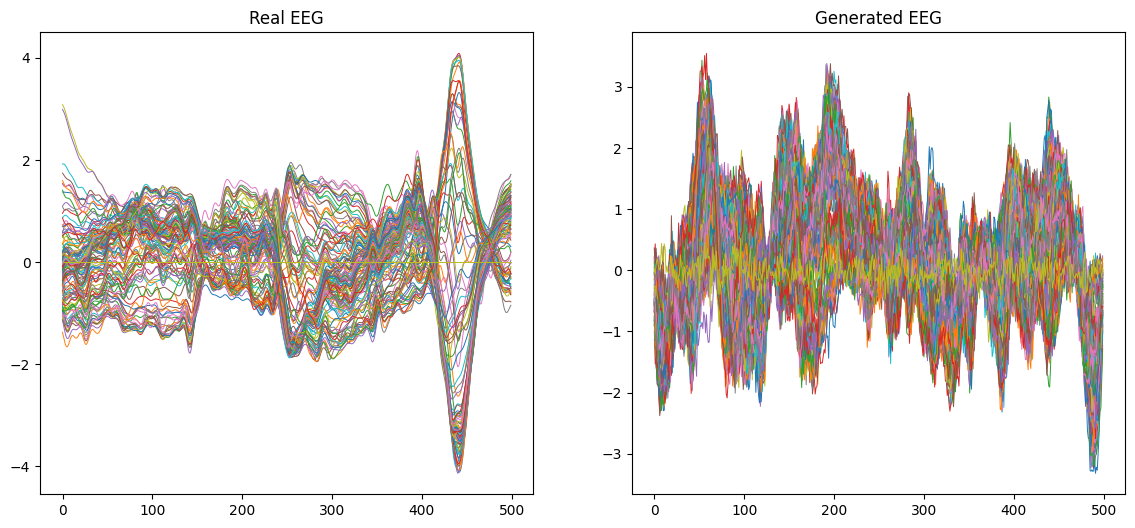

✓ Saved PSD arrays → ../../figures/psd


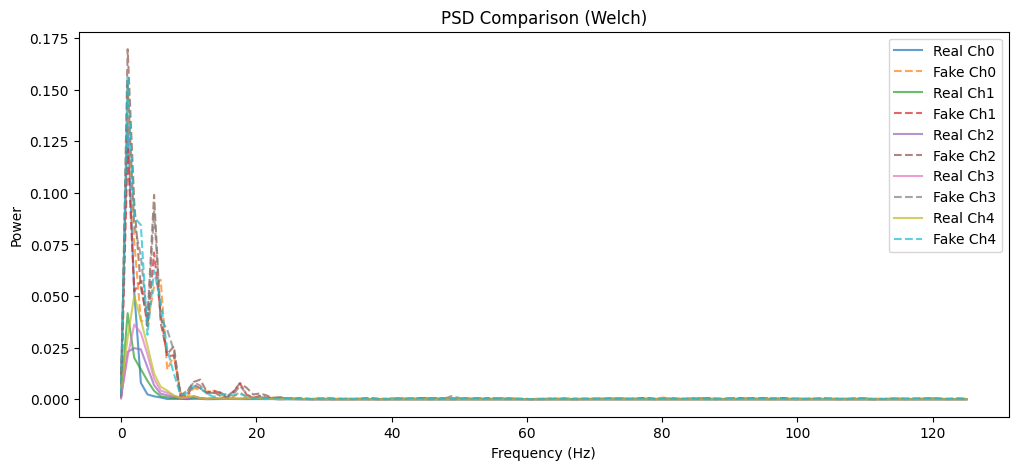

✓ Saved models → ../../models/eyes_open_G.pt and _D.pt


In [4]:
# Train eyes open GAN (data already loaded above)
print(f"✓ Using eyes open data: {segments_open.shape}")

# TRAIN IN 3 LINES!
trainer_open = EEGGANTrainer(segments_open, name='eyes_open', device=device, gan_type='wgan-gp')
trainer_open.train()
synthetic_open = trainer_open.generate(n_samples=100)

# Evaluate
eval_open = trainer_open.evaluate(synthetic_open)
print("\n" + "="*60)
print("EVALUATION RESULTS: EYES OPEN")
print("="*60)
for key, value in eval_open.items():
    print(f"  {key}: {value}")
print("="*60)

# Visualize
trainer_open.plot_comparison(synthetic_open, save_path='../../figures/eyes_open_gan.png')

trainer_open.save_psd(
    real=trainer_open.data[:10],
    fake=synthetic_open[:10],
    save_dir='../../figures/psd'
)

trainer_open.plot_psd_comparison(
    real=trainer_open.data[:1],
    fake=synthetic_open[:1],
    save_path='../../figures/psd_open.png'
)

trainer_open.save_models(directory='../../models')

✓ Using eyes closed data: (444, 129, 500)
Initialized EEGGANTrainer (wgan-gp) — eyes_closed
  Data: (444, 129, 500)
  Device: cuda
⚠️ WARNING: Small dataset detected (<500)
   → Using smaller models
   → Early stopping enabled
✓ Created Conv1D Generator + Critic
  G params: 6,937,541
  D params: 345,217
✓ Dataset loaded: 444 samples

=== Training WGAN-GP ===
✓ Saved checkpoint → ../../models/gan_eyes_closed_wgan-gp.pt
Epoch 10/100 | G=-72.1436 | D=-289.2914 | Metric=0.0866 | ✓ NEW BEST
✓ Saved checkpoint → ../../models/gan_eyes_closed_wgan-gp.pt
Epoch 20/100 | G=-41.8347 | D=-114.3027 | Metric=0.0826 | ✓ NEW BEST
✓ Saved checkpoint → ../../models/gan_eyes_closed_wgan-gp.pt
Epoch 30/100 | G=-11.5540 | D=-70.8527 | Metric=0.0389 | ✓ NEW BEST
✓ Saved checkpoint → ../../models/gan_eyes_closed_wgan-gp.pt
Epoch 40/100 | G=9.9780 | D=-59.7385 | Metric=0.0169 | ✓ NEW BEST
Epoch 50/100 | G=5.8493 | D=-37.4372 | Metric=0.0348 | no improve 1
Epoch 60/100 | G=1.9761 | D=-29.1220 | Metric=0.0200 | 

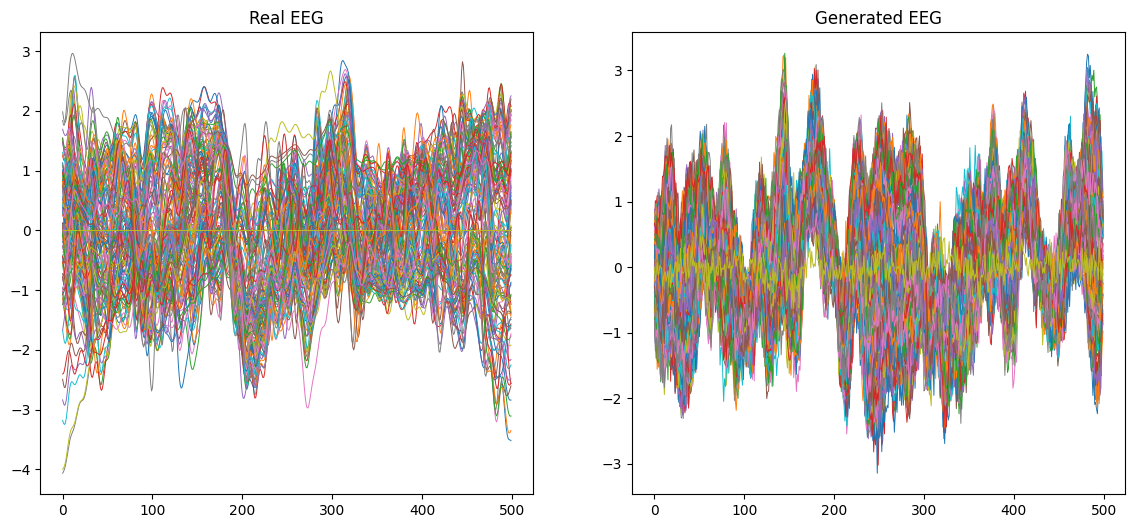

✓ Saved PSD arrays → ../../figures/psd


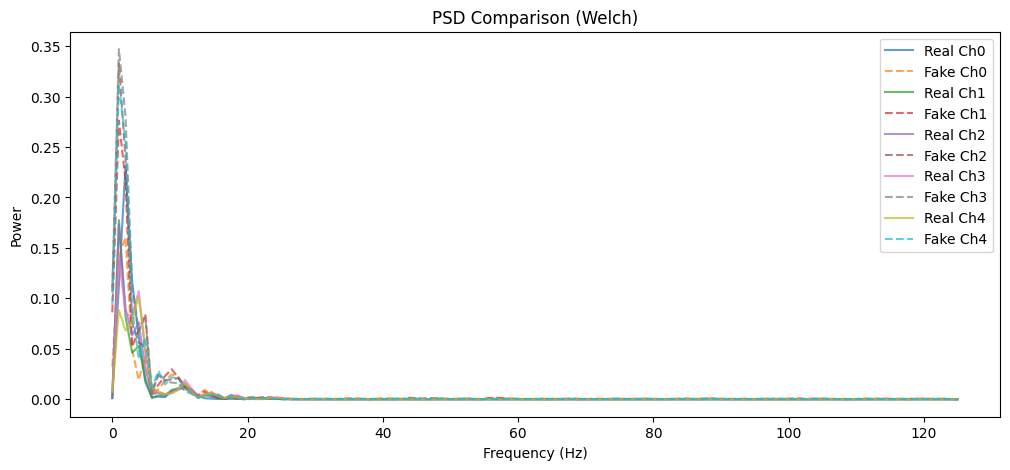

✓ Saved models → ../../models/eyes_closed_G.pt and _D.pt


In [5]:
# Train eyes closed GAN (data already loaded above)
print(f"✓ Using eyes closed data: {segments_closed.shape}")
            
# TRAIN IN 3 LINES!
trainer_closed = EEGGANTrainer(segments_closed, name='eyes_closed', device=device, gan_type='wgan-gp')
trainer_closed.train()
synthetic_closed = trainer_closed.generate(n_samples=100)

# Evaluate
eval_closed = trainer_closed.evaluate(synthetic_closed)
print("\n" + "="*60)
print("EVALUATION RESULTS: EYES CLOSED")
print("="*60)
for key, value in eval_closed.items():
    print(f"  {key}: {value}")
print("="*60)

# Visualize
trainer_closed.plot_comparison(synthetic_closed, save_path='../../figures/eyes_closed_gan.png')

trainer_closed.save_psd(
    real=trainer_closed.data[:10],
    fake=synthetic_closed[:10],
    save_dir='../../figures/psd'
)

trainer_closed.plot_psd_comparison(
    real=trainer_closed.data[:1],
    fake=synthetic_closed[:1],
    save_path='../../figures/psd_closed.png'
)

trainer_closed.save_models(directory='../../models')

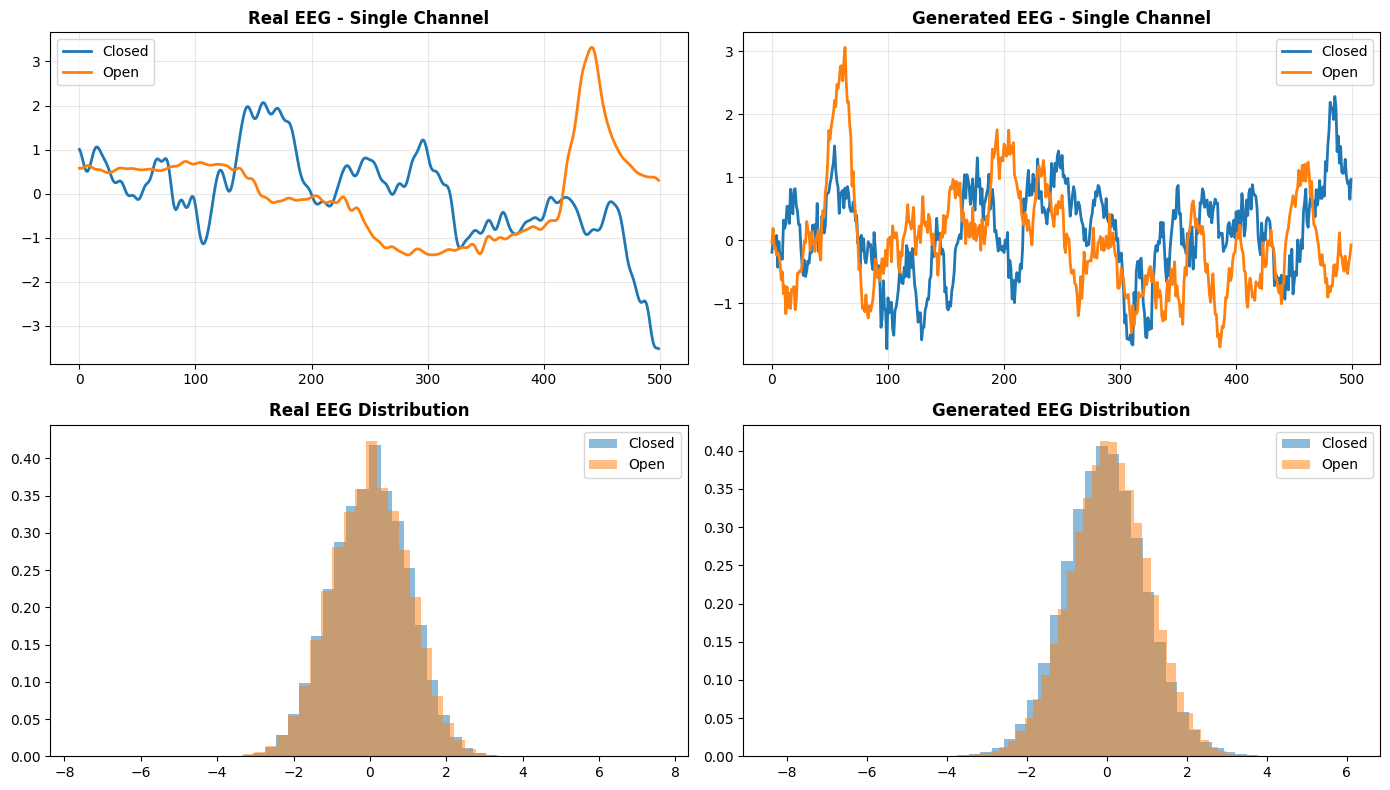


FINAL SUMMARY

Eyes Closed:
  Quality Score: 50.8/100
  Rating: Fair ⭐⭐⭐

Eyes Open:
  Quality Score: 40.6/100
  Rating: Fair ⭐⭐⭐

Average: 45.7/100


In [6]:
# Side-by-side comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(segments_closed[0, 0], label='Closed', linewidth=2)
axes[0, 0].plot(segments_open[0, 0], label='Open', linewidth=2)
axes[0, 0].set_title('Real EEG - Single Channel', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(synthetic_closed[0, 0], label='Closed', linewidth=2)
axes[0, 1].plot(synthetic_open[0, 0], label='Open', linewidth=2)
axes[0, 1].set_title('Generated EEG - Single Channel', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(segments_closed.flatten(), bins=50, alpha=0.5, label='Closed', density=True)
axes[1, 0].hist(segments_open.flatten(), bins=50, alpha=0.5, label='Open', density=True)
axes[1, 0].set_title('Real EEG Distribution', fontweight='bold')
axes[1, 0].legend()

axes[1, 1].hist(synthetic_closed.flatten(), bins=50, alpha=0.5, label='Closed', density=True)
axes[1, 1].hist(synthetic_open.flatten(), bins=50, alpha=0.5, label='Open', density=True)
axes[1, 1].set_title('Generated EEG Distribution', fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../../figures/closed_vs_open_final.png', dpi=150)
plt.show()

# Summary report
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"\nEyes Closed:")
print(f"  Quality Score: {eval_closed['overall_score']:.1f}/100")
print(f"  Rating: {eval_closed['quality']}")
print(f"\nEyes Open:")
print(f"  Quality Score: {eval_open['overall_score']:.1f}/100")
print(f"  Rating: {eval_open['quality']}")
print(f"\nAverage: {(eval_closed['overall_score'] + eval_open['overall_score'])/2:.1f}/100")
print("="*70)


SAVING RESULTS
✓ Saved results for eyes_closed (wgan-gp)


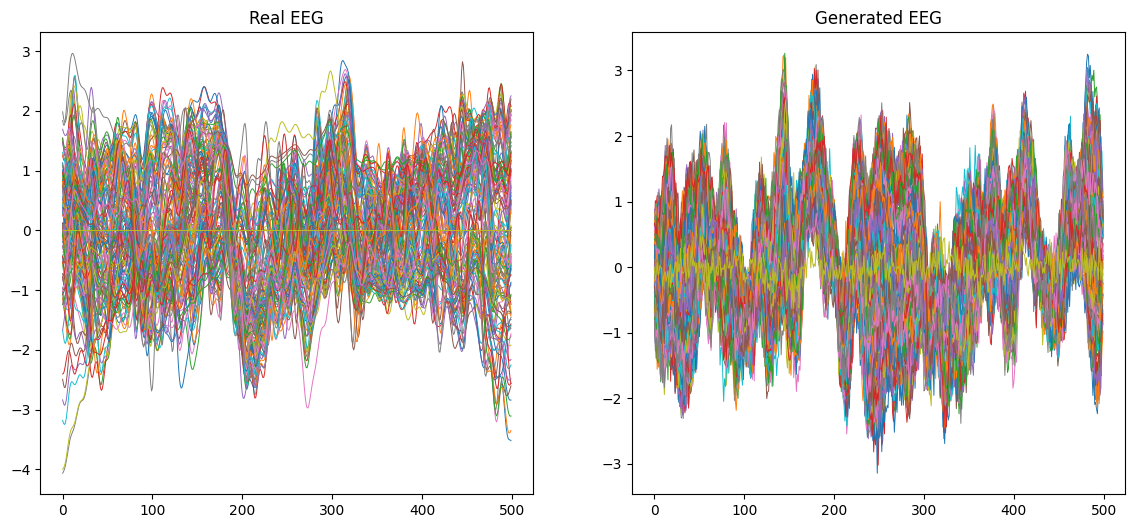

✓ Saved models → ../../models/eyes_closed_G.pt and _D.pt
✓ Saved results for eyes_open (wgan-gp)


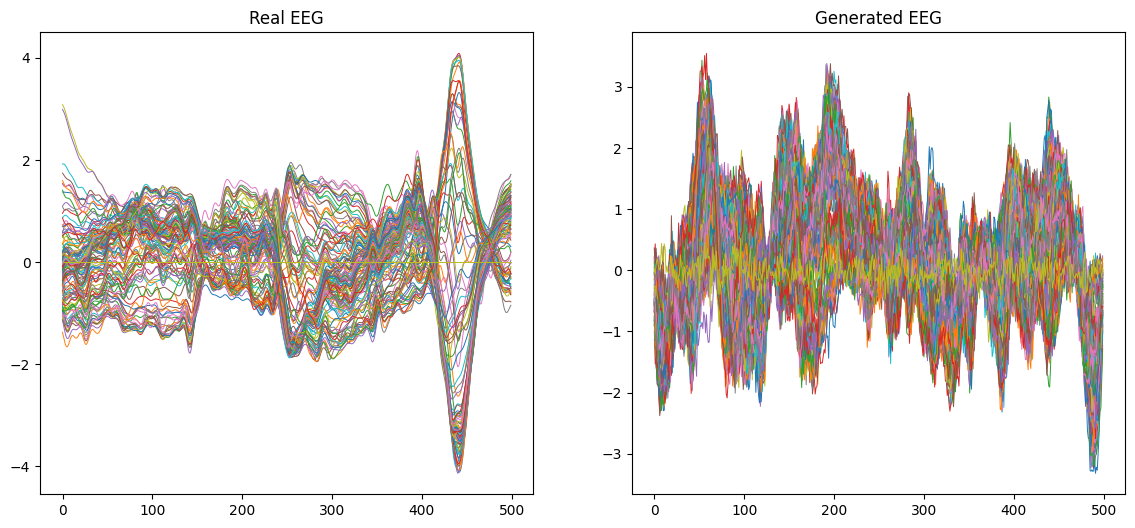

✓ Saved models → ../../models/eyes_open_G.pt and _D.pt

✓ All results saved!


In [7]:
# Save all results at the end
print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

# Save closed
trainer_closed.save_results(synthetic_closed, eval_closed)
trainer_closed.plot_comparison(synthetic_closed, save_path='../../figures/eyes_closed_gan.png')
trainer_closed.save_models(directory='../../models')

# Save open
trainer_open.save_results(synthetic_open, eval_open)
trainer_open.plot_comparison(synthetic_open, save_path='../../figures/eyes_open_gan.png')
trainer_open.save_models(directory='../../models')

print("\n✓ All results saved!")
print("="*70)